# Main - facial expression analysis

Using this code can help analyse synchrony in facial expressions. 

In [25]:
# Import required packages

# Import packages
import glob
import os
from pathlib import Path
#import pyxdf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from scipy.interpolate import interp1d
from itertools import combinations



In [28]:
filename = r'..\data-in\19_20\pp19_navigator_video_frames_discussion_phase_1.txt'
actual_frames = np.loadtxt(filename, delimiter=',')
print(len(actual_frames))

NameError: name 'implement_array_function' is not defined

## Rewrapping video
The rewrapping of the video is needed since some files do not have meta data, however there is a video. Rewrapping the videos solves this problem.

In [ ]:
# Import the function
from functions_face_rewrap_video import rewrap_video
import cv2

%load_ext autoreload
%autoreload 2 

path_to_data = r"..\data-in"
save_path =    r"..\data-out"

for team_folder in tqdm(os.listdir(path_to_data)):

    if team_folder == '11_12' or team_folder == '21_22':
        continue

    path_to_team_folder = os.path.join(path_to_data, team_folder)
    path_to_analysis_folder = os.path.join(path_to_team_folder, "analysis")
    path_to_avi_files = glob.glob(os.path.join(path_to_team_folder, "*.avi"))

    for file in path_to_avi_files:
        rewrap_video(file, save_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/2 [00:00<?, ?it/s]

..\data-in\facial_expression\pp19_navigator_discussion_phase_0_reconstructed_video.avi
Video already has metadata


..\data-in\facial_expression\pp19_navigator_discussion_phase_0_reconstructed_video_no_black.avi
Video already has metadata


..\data-in\facial_expression\pp19_navigator_discussion_phase_1_reconstructed_video.avi
Video already has metadata


..\data-in\facial_expression\pp19_navigator_discussion_phase_1_reconstructed_video_no_black.avi
Video already has metadata


..\data-in\facial_expression\pp19_navigator_instructional_video_0_reconstructed_video.avi


100%|██████████| 2/2 [00:00<00:00,  5.74it/s]

Video already has metadata


..\data-in\facial_expression\pp19_navigator_instructional_video_0_reconstructed_video_no_black.avi
Video already has metadata


..\data-in\facial_expression\pp20_pilot_discussion_phase_0_reconstructed_video.avi
Video already has metadata


..\data-in\facial_expression\pp20_pilot_discussion_phase_0_reconstructed_video_no_black.avi
Video already has metadata


..\data-in\facial_expression\pp20_pilot_discussion_phase_1_reconstructed_video.avi
Video already has metadata


..\data-in\facial_expression\pp20_pilot_discussion_phase_1_reconstructed_video_no_black.avi
Video already has metadata


..\data-in\facial_expression\pp20_pilot_instructional_video_0_reconstructed_video.avi
Video already has metadata


..\data-in\facial_expression\pp20_pilot_instructional_video_0_reconstructed_video_no_black.avi
Video already has metadata




### Merge audio and video
Merging the audio with the video can help to detect where the missing frames are. 

In [ ]:
from merge_video_audio import merge_audio_video

video_path = os.path.join(path_to_data, "pp20_pilot_reconstructed_video_and_audio_discussion_phase_0.mp4")
audio_path = os.path.join(path_to_data, "pp20_pilot_audio_discussion_phase_0.wav")
output_path = os.path.join(save_path,'pilot_20_audio_video.avi')

merge_audio_video(video_path, audio_path, output_path)

{'video_found': False, 'audio_found': False, 'metadata': {}, 'inputs': [{'streams': [None]}], 'video_n_frames': 0, 'video_duration': 0.0}
C:\Users\Erik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\imageio_ffmpeg\binaries\ffmpeg-win-x86_64-v7.1.exe -i ..\data-in\pp20_pilot_reconstructed_video_and_audio_discussion_phase_0.mp4 -loglevel error -f image2pipe -vf scale=1:1 -sws_flags bicubic -pix_fmt rgb24 -vcodec rawvideo -


C:\Users\Erik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\moviepy\video\io\ffmpeg_reader.py:178: UserWarning: In file ..\data-in\pp20_pilot_reconstructed_video_and_audio_discussion_phase_0.mp4, 3 bytes wanted but 0 bytes read at frame index 0 (out of a total 0 frames), at time 0.00/0.00 sec. Using the last valid frame instead.
  warnings.warn(


OSError: MoviePy error: failed to read the first frame of video file ..\data-in\pp20_pilot_reconstructed_video_and_audio_discussion_phase_0.mp4. That might mean that the file is corrupted. That may also mean that you are using a deprecated version of FFMPEG. On Ubuntu/Debian for instance the version in the repos is deprecated. Please update to a recent version from the website.

## Generating action units

Several functions are used: 
- trim v2: trims the videos in the phases you are interested in using the markers. 
- AU: generates AU using OpenFace
- AU NaN: adds NaN values at the locatio of the missing frames
- AU recovered: interpolates the missing values. 

In [27]:
# Import the function
from functions_face_trim_v2 import process_participant_videos2
from functions_face_AU import get_AU
from functions_face_AU_NaN import NaN_AU_csv
from functions_face_AU_recovered import handle_missing_data


%load_ext autoreload
%autoreload 2 

path_to_new_data = "../data-in"
#path_to_data = r"\\tsn.tno.nl\data\projects\060\5\57452\Werkdocumenten\data"
roles = ['pilot', 'navigator']

for id, team_folder in enumerate(tqdm(os.listdir(path_to_new_data))):
    #team_folders_to_continue = ['05_06', '07_08', '09_10', '11_12','17_18','19_20', '21_22', '25_26', '29_30', '31_32'] 
    team_folders_to_continue = ['05_06', '21_22'] 

    if team_folder not in team_folders_to_continue:
        continue


    participant_ids = team_folder.split('_')
    
    # ------ added by Femke ------ #
    path_to_analysis_folder = os.path.join(path_to_new_data, team_folder, "analysis")

    for participant_id in participant_ids:
        #print(participant_id)
        process_participant_videos2(path_to_analysis_folder, path_to_avi_files, participant_id) #trim video
        get_AU(path_to_analysis_folder,participant_id) #generate AU
        NaN_AU_csv(path_to_analysis_folder, participant_id) #add NaN on the location of the missing frames
        handle_missing_data(path_to_analysis_folder, participant_id) #interpolate NaN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 1/1 [00:00<?, ?it/s]


### Factor analysis
- factors: Summing AUs into factors (see report for more details)
- factors results: computes the DTW distance and PC using factor as feature selection 

The analysis will be done on real and fake pairs. 

Real pairs

In [ ]:
from functions_face_factors import get_factors
from functions_face_factors_results import compute_results_factors
%load_ext autoreload
%autoreload 2 


for id, team_folder in enumerate(tqdm(os.listdir(path_to_new_data))):
    team_folders_to_continue = ['05_06', '07_08', '09_10','17_18','19_20', '21_22', '25_26', '29_30', '31_32', '33_34'] 

    if team_folder not in team_folders_to_continue:
        continue   

    participant_ids = team_folder.split('_')
    #path_to_analysis_folder = os.path.join(path_to_new_data, team_folder, "analysis")
    path_to_result_folder = os.path.join(path_to_new_data, 'Results facial expressions')

    for participant_id in participant_ids:
        get_factors(path_to_analysis_folder, participant_id)
    
    #-------------------- compute results of factors for real pairs -------------------------
    for i in range(0, len(participant_ids), 2):
        if i + 1 < len(participant_ids):
            participant_id1 = participant_ids[i]
            participant_id2 = participant_ids[i + 1]
            compute_results_factors(path_to_analysis_folder,path_to_result_folder, participant_id1, participant_id2)

 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/2 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '../data-in\\19_20\\analysis\\Video\\pp19_navigator_video_frames.csv'

Fake pairs 

In [ ]:
import os
import random
from tqdm import tqdm
from functions_face_factors import get_factors
from functions_face_factors_results_fake import compute_results_factors_fake

%load_ext autoreload
%autoreload 2 
all_participant_ids = []

for id, team_folder in enumerate(tqdm(os.listdir(path_to_new_data))):
    path_to_team_folder = os.path.join(path_to_new_data, team_folder)
    path_to_analysis_folder = os.path.join(path_to_new_data, team_folder, "analysis")
    path_to_result_folder = os.path.join(path_to_new_data, 'Results facial expressions')
    
    team_folders_to_continue = ['05_06', '07_08', '09_10','17_18','19_20', '21_22', '25_26', '29_30', '31_32', '33_34'] 
    if team_folder not in team_folders_to_continue:
        continue   

    participant_ids = team_folder.split('_')
    all_participant_ids.extend(participant_ids)

used_participant_ids = set()

for id, team_folder in enumerate(tqdm(os.listdir(path_to_new_data))):
    path_to_team_folder = os.path.join(path_to_new_data, team_folder)
    path_to_analysis_folder = os.path.join(path_to_new_data, team_folder, "analysis")
    path_to_result_folder = os.path.join(path_to_new_data, 'Results facial expressions')
    
    team_folders_to_continue = ['05_06', '07_08', '09_10','17_18','19_20', '21_22', '25_26', '29_30', '31_32', '33_34'] 
    if team_folder not in team_folders_to_continue:
        continue   
    
    participant_ids = team_folder.split('_') 

    for participant_id in participant_ids:
        for i in range(0, len(participant_ids), 2):
            if i + 1 < len(participant_ids):
                participant_id1 = participant_ids[i]
                participant_id2 = participant_ids[i + 1]
                
                if participant_id1 in used_participant_ids:
                    continue

                # Filter out participant_id1 and participant_id2 from the list
                available_ids = [pid for pid in all_participant_ids if pid != participant_id1 and pid != participant_id2]
                # Separate odd and even IDs
                odd_ids = [pid for pid in available_ids if int(pid) % 2 != 0]
                #print(odd_ids)
                even_ids = [pid for pid in available_ids if int(pid) % 2 == 0]

                # Select random_participant_id2 (even)
                random_participant_id2 = random.choice(even_ids)
                #print(random_participant_id2)
                compute_results_factors_fake(path_to_new_data, path_to_result_folder, participant_id1, random_participant_id2)
                used_participant_ids.add(participant_id1)
                break


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/32 [00:00<?, ?it/s]

Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp05_pp32_fake_instructional_video_0_result_factor.csv - fake - pp05-pp32
Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp05_pp32_fake_discussion_phase_0_result_factor.csv - fake - pp05-pp32


  3%|▎         | 1/32 [01:01<31:46, 61.50s/it]

Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp05_pp32_fake_discussion_phase_1_result_factor.csv - fake - pp05-pp32
Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp07_pp26_fake_instructional_video_0_result_factor.csv - fake - pp07-pp26
Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp07_pp26_fake_discussion_phase_0_result_factor.csv - fake - pp07-pp26


  6%|▋         | 2/32 [02:33<39:38, 79.28s/it]

Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp07_pp26_fake_discussion_phase_1_result_factor.csv - fake - pp07-pp26
Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp09_pp26_fake_instructional_video_0_result_factor.csv - fake - pp09-pp26
Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp09_pp26_fake_discussion_phase_0_result_factor.csv - fake - pp09-pp26


  9%|▉         | 3/32 [04:00<40:08, 83.05s/it]

Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp09_pp26_fake_discussion_phase_1_result_factor.csv - fake - pp09-pp26
Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp17_pp08_fake_instructional_video_0_result_factor.csv - fake - pp17-pp08
Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp17_pp08_fake_discussion_phase_0_result_factor.csv - fake - pp17-pp08


 22%|██▏       | 7/32 [05:32<16:30, 39.60s/it]

Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp17_pp08_fake_discussion_phase_1_result_factor.csv - fake - pp17-pp08
Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp19_pp06_fake_instructional_video_0_result_factor.csv - fake - pp19-pp06
Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp19_pp06_fake_discussion_phase_0_result_factor.csv - fake - pp19-pp06


 25%|██▌       | 8/32 [07:01<19:52, 49.67s/it]

Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp19_pp06_fake_discussion_phase_1_result_factor.csv - fake - pp19-pp06
Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp21_pp06_fake_instructional_video_0_result_factor.csv - fake - pp21-pp06
Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp21_pp06_fake_discussion_phase_0_result_factor.csv - fake - pp21-pp06


 28%|██▊       | 9/32 [08:38<23:11, 60.49s/it]

Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp21_pp06_fake_discussion_phase_1_result_factor.csv - fake - pp21-pp06
Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp25_pp30_fake_instructional_video_0_result_factor.csv - fake - pp25-pp30
Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp25_pp30_fake_discussion_phase_0_result_factor.csv - fake - pp25-pp30


 34%|███▍      | 11/32 [10:11<19:15, 55.01s/it]

Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp25_pp30_fake_discussion_phase_1_result_factor.csv - fake - pp25-pp30
Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp29_pp22_fake_instructional_video_0_result_factor.csv - fake - pp29-pp22
Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp29_pp22_fake_discussion_phase_0_result_factor.csv - fake - pp29-pp22


 41%|████      | 13/32 [11:48<16:38, 52.57s/it]

Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp29_pp22_fake_discussion_phase_1_result_factor.csv - fake - pp29-pp22
Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp31_pp34_fake_instructional_video_0_result_factor.csv - fake - pp31-pp34
Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp31_pp34_fake_discussion_phase_0_result_factor.csv - fake - pp31-pp34


 44%|████▍     | 14/32 [13:32<18:56, 63.12s/it]

Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp31_pp34_fake_discussion_phase_1_result_factor.csv - fake - pp31-pp34
Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp33_pp08_fake_instructional_video_0_result_factor.csv - fake - pp33-pp08
Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp33_pp08_fake_discussion_phase_0_result_factor.csv - fake - pp33-pp08


100%|██████████| 32/32 [15:09<00:00, 28.43s/it]

Factors results saved to ../../Experiment/data\Results facial expressions\Factor\pp33_pp08_fake_discussion_phase_1_result_factor.csv - fake - pp33-pp08


- stastistics factors: makes box plots of results and saves the p-values in the results folder. 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\Users\hoekstraf\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


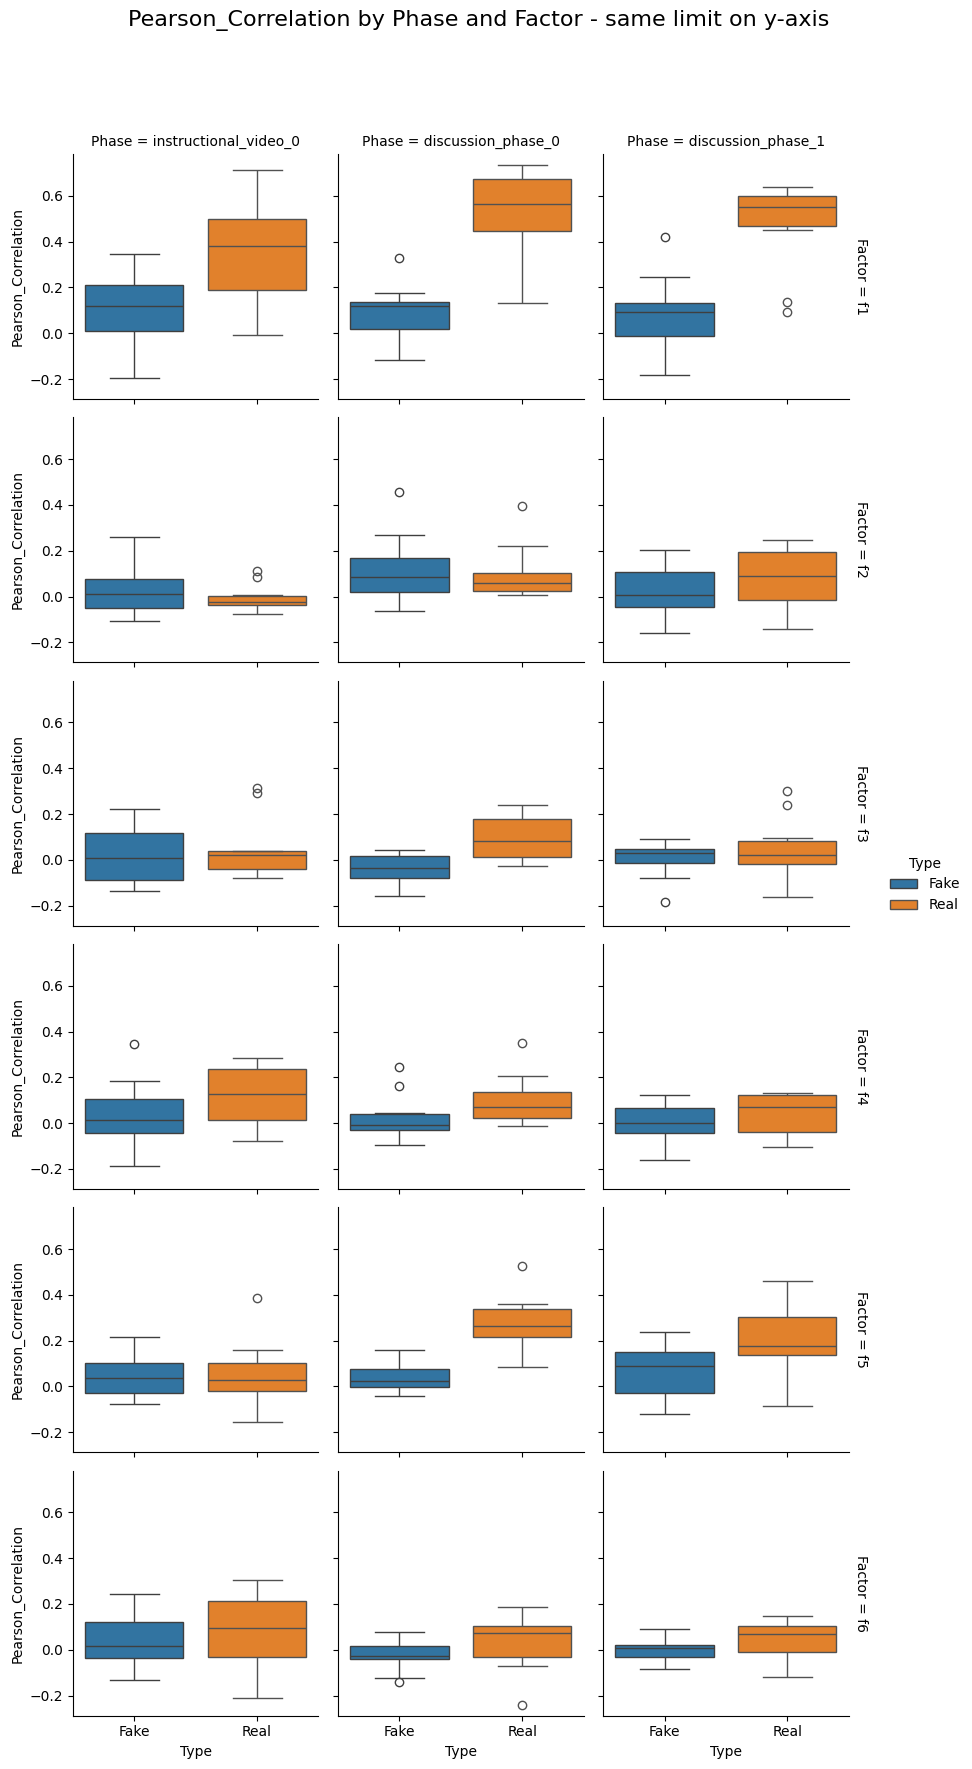

c:\Users\hoekstraf\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


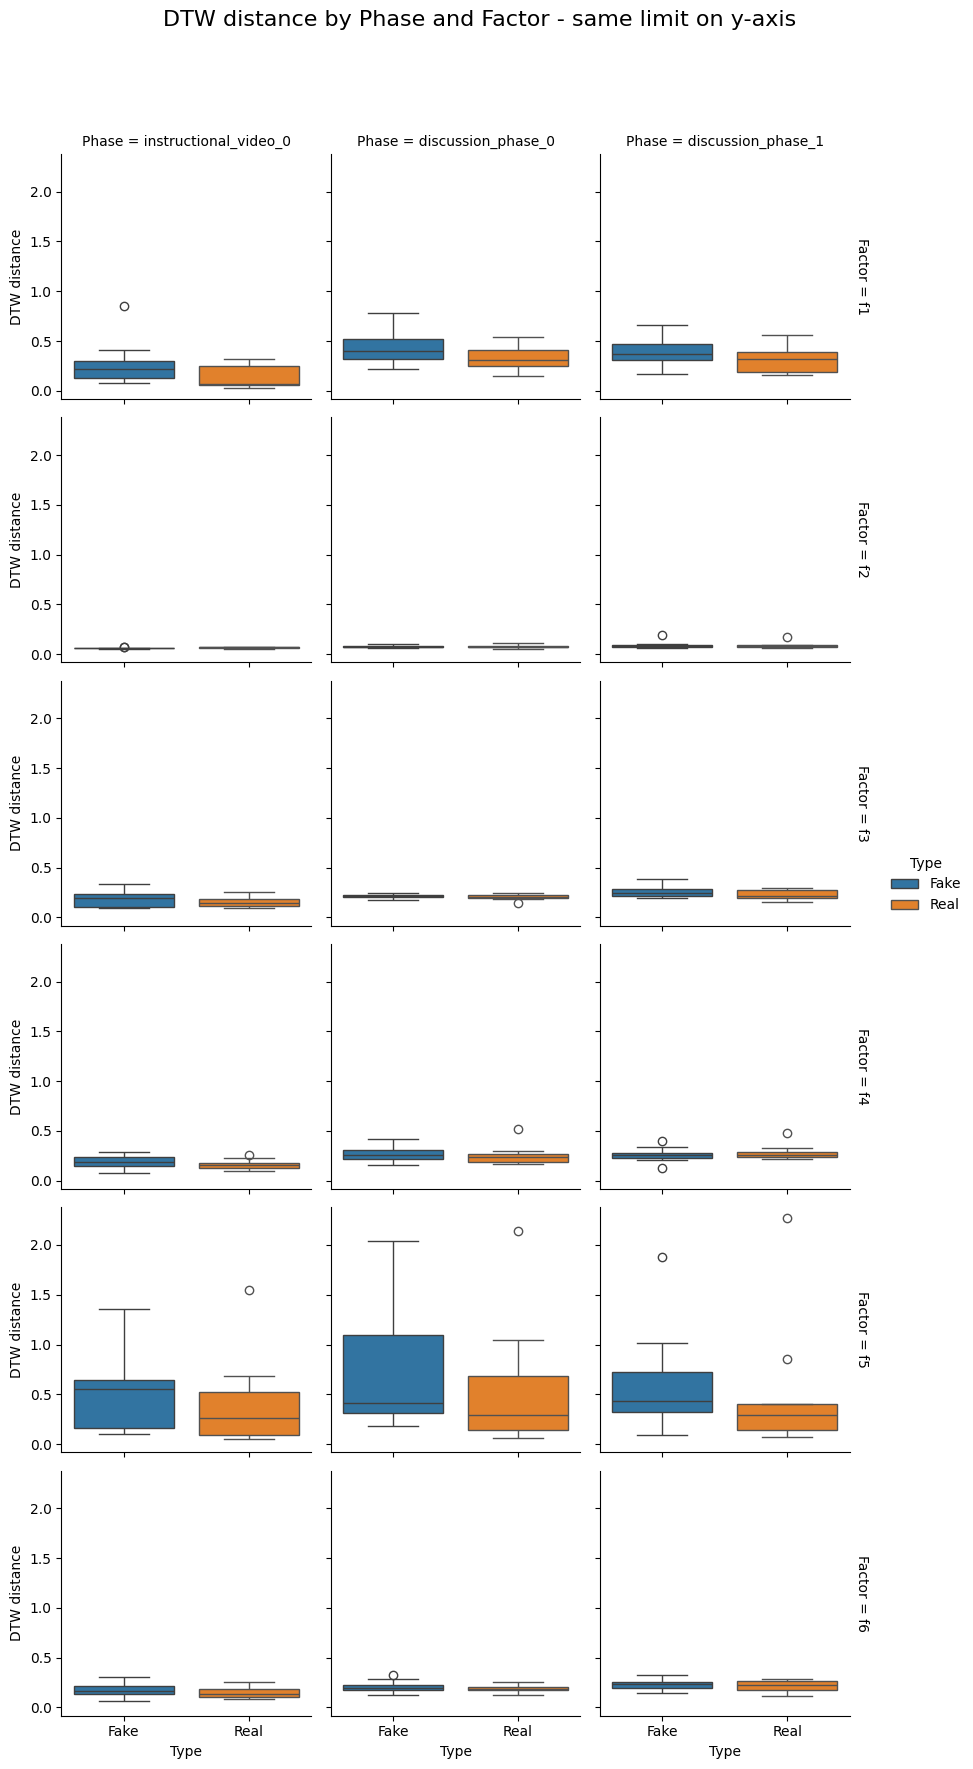

c:\Users\hoekstraf\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


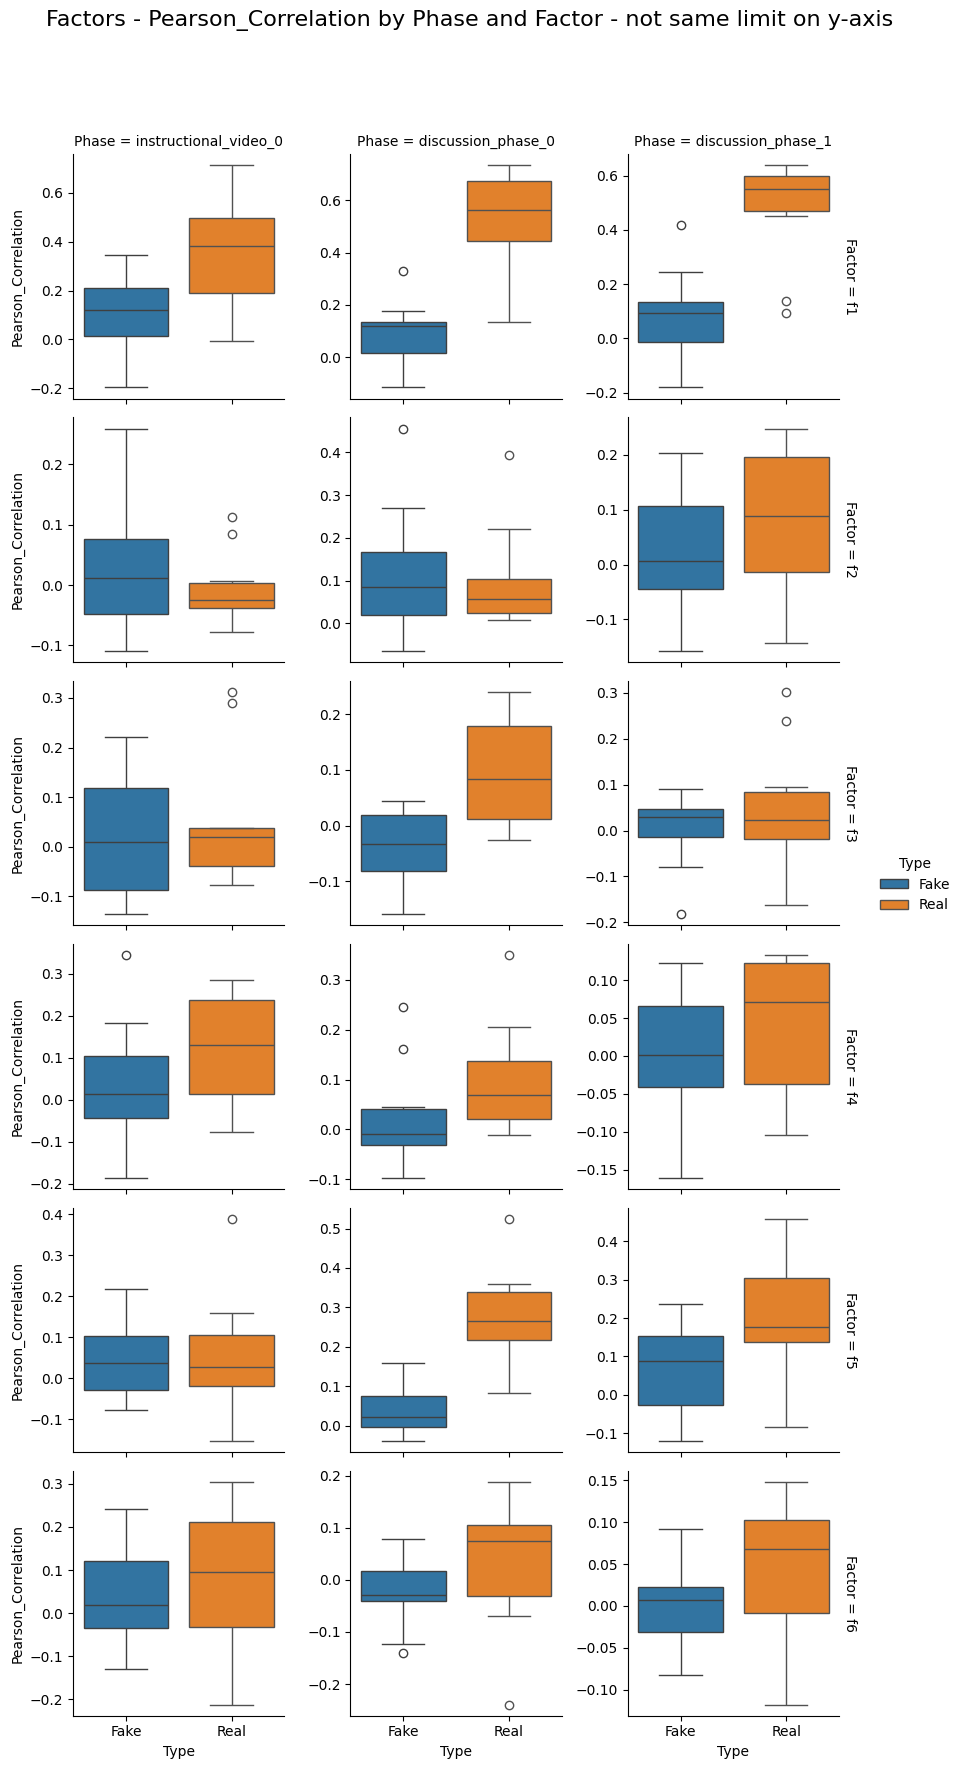

c:\Users\hoekstraf\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


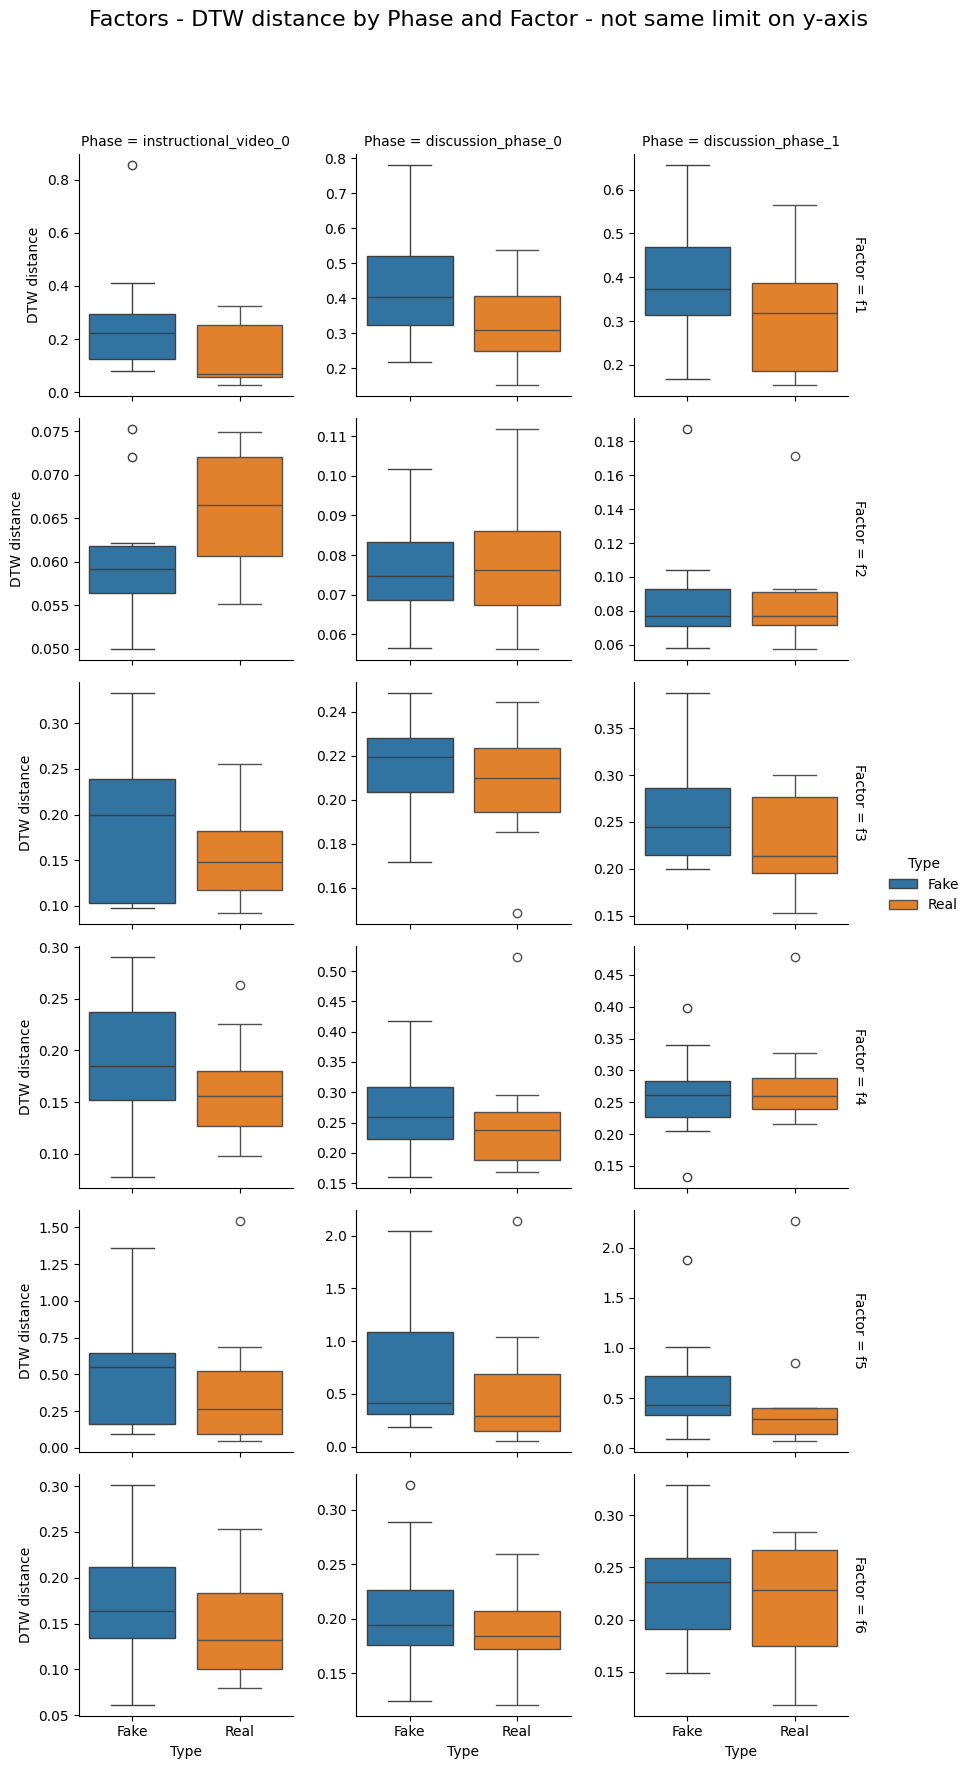

In [ ]:
from functions_face_statistics_factors import load_results
%load_ext autoreload
%autoreload 2 
path_to_new_data = "../../Experiment/data"
path_to_result_factor_folder = os.path.join(path_to_new_data, 'Results facial expressions', 'Factor')

load_results(path_to_new_data,path_to_result_factor_folder)

### CorrCA analysis
The other feature selection method is CorrCA. The functions that are used are:
- corrCA dataframe v2: in this function the data of all participants will be added into one data frame (input of corrCA function)
- corrCA w: input dataframe of all partipants and corrCA will be applied, output is the weight factor w. 

In [ ]:
#Import the function
from functions_face_corrCA_dataframe_v2 import corrCA_dataframe
from functions_face_corrCA_w import load_and_apply_corrca


%load_ext autoreload
%autoreload 2 

path_to_new_data = "../../Experiment/data"
#path_to_data = r"\\tsn.tno.nl\data\projects\060\5\57452\Werkdocumenten\data"
roles = ['pilot', 'navigator']

all_participant_ids = []
all_path_AU_files = []

# location of all the AU files is found:
for id, team_folder in enumerate(tqdm(os.listdir(path_to_new_data))):
    team_folders_to_continue = ['05_06', '07_08', '09_10','17_18','19_20', '21_22', '25_26', '29_30', '31_32', '33_34'] #35_36, 41-42, '43_44' ,'49_50', '55_56' missing files
    if team_folder not in team_folders_to_continue:
        continue   

    participant_ids = team_folder.split('_')
    all_participant_ids.extend(participant_ids)

    for participant_id in participant_ids: 
        role = 'navigator' if int(participant_id) % 2 != 0 else 'pilot'
        path_to_analysis_folder = os.path.join(path_to_new_data, team_folder, "analysis")
        path_to_video_folder = os.path.join(path_to_analysis_folder, 'Video')
        facial_expression_folder = os.path.join(path_to_analysis_folder, 'facial_expression')
    
        csv_filename = f"pp{participant_id}_{role}_video_frames.csv"
        path_to_frame_csv_file = os.path.join(path_to_video_folder, csv_filename)
        if not os.path.exists(path_to_frame_csv_file):
            print(f"File {path_to_frame_csv_file} not found. Skipping participant {participant_id}.")
            continue
        frame_data_csv = pd.read_csv(path_to_frame_csv_file)
        for index, row in frame_data_csv.iterrows():
                name = row['name']
                AU_file = f"pp{participant_id}_{role}_{name}_output_au_no_black_recovered.csv"
                path_AU_file = os.path.join(facial_expression_folder, AU_file)
                #print(path_AU_file)
                all_path_AU_files.append(path_AU_file)
print(all_path_AU_files)

#make one dataframe of all AU data
corrCA_dataframe(path_to_new_data, all_path_AU_files)
#apply corrCA
load_and_apply_corrca(path_to_new_data)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 32/32 [00:00<00:00, 95.06it/s]


['../../Experiment/data\\05_06\\analysis\\facial_expression\\pp05_navigator_instructional_video_0_output_au_no_black_recovered.csv', '../../Experiment/data\\05_06\\analysis\\facial_expression\\pp05_navigator_discussion_phase_0_output_au_no_black_recovered.csv', '../../Experiment/data\\05_06\\analysis\\facial_expression\\pp05_navigator_discussion_phase_1_output_au_no_black_recovered.csv', '../../Experiment/data\\05_06\\analysis\\facial_expression\\pp06_pilot_instructional_video_0_output_au_no_black_recovered.csv', '../../Experiment/data\\05_06\\analysis\\facial_expression\\pp06_pilot_discussion_phase_0_output_au_no_black_recovered.csv', '../../Experiment/data\\05_06\\analysis\\facial_expression\\pp06_pilot_discussion_phase_1_output_au_no_black_recovered.csv', '../../Experiment/data\\07_08\\analysis\\facial_expression\\pp07_navigator_instructional_video_0_output_au_no_black_recovered.csv', '../../Experiment/data\\07_08\\analysis\\facial_expression\\pp07_navigator_discussion_phase_0_outpu

CorrCA results 
- corrCA y: calculates the weighted output (y) for every participant 
- corrCA results: DTW and PC is calculated on the two weighted outputs of the *real* participants (y1 and y2). 

In [ ]:
from functions_face_corrCA_y import get_y
from functions_face_corrCA_results import compute_results_corrCA
%load_ext autoreload
%autoreload 2 
path_to_result_folder = os.path.join(path_to_new_data, 'Results facial expressions')
#path_to_data = r"\\tsn.tno.nl\data\projects\060\5\57452\Werkdocumenten\data"

for id, team_folder in enumerate(tqdm(os.listdir(path_to_new_data))):
    team_folders_to_continue = ['05_06', '07_08', '09_10','17_18','19_20', '21_22', '25_26', '29_30', '31_32', '33_34'] 
    if team_folder not in team_folders_to_continue:
        continue   

    # if id > 14:
    #     continue

    participant_ids = team_folder.split('_')
    path_to_team_folder = os.path.join(path_to_new_data, team_folder)
    
    # ------ added by Femke ------ #
    path_to_analysis_folder = os.path.join(path_to_new_data, team_folder, "analysis")
    path_to_avi_files = glob.glob(os.path.join(path_to_team_folder, "*.avi"))

    for participant_id in participant_ids:
        get_y(path_to_new_data, path_to_analysis_folder, participant_id)
    
    #compute results of factors for real pairs 
    for i in range(0, len(participant_ids), 2):
        if i + 1 < len(participant_ids):
            participant_id1 = participant_ids[i]
            print(f'pp1: {participant_id1}')
            participant_id2 = participant_ids[i + 1]
            print(f'pp2: {participant_id2}')
            compute_results_corrCA(path_to_analysis_folder, path_to_result_folder, participant_id1, participant_id2)


KeyboardInterrupt: 

- CorrCA results fake: DTW and PC is calculated using the weighted outputs (y1 and y2) of the fake pairs. 

In [ ]:

import os
import random
from tqdm import tqdm
from functions_face_corrCA_results_fake import compute_results_corrCA_fake

%load_ext autoreload
%autoreload 2 
path_to_new_data = "../../Experiment/data"


all_participant_ids = []
for id, team_folder in enumerate(tqdm(os.listdir(path_to_new_data))):
    path_to_team_folder = os.path.join(path_to_new_data, team_folder)
    path_to_analysis_folder = os.path.join(path_to_new_data, team_folder, "analysis")
    path_to_result_folder = os.path.join(path_to_new_data, 'Results facial expressions')
    
    team_folders_to_continue = ['05_06', '07_08', '09_10','17_18','19_20', '21_22', '25_26', '29_30', '31_32', '33_34']  #35_36, 41-42, '43_44' ,'49_50', '55_56' missing files
    if team_folder not in team_folders_to_continue:
        continue   

    if id > 14:
        continue
    participant_ids = team_folder.split('_')
    all_participant_ids.extend(participant_ids)

used_participant_ids = set()

for id, team_folder in enumerate(tqdm(os.listdir(path_to_new_data))):
    path_to_team_folder = os.path.join(path_to_new_data, team_folder)
    path_to_analysis_folder = os.path.join(path_to_new_data, team_folder, "analysis")
    path_to_result_folder = os.path.join(path_to_new_data, 'Results facial expressions')
    
    team_folders_to_continue = ['05_06', '07_08', '09_10','17_18','19_20', '21_22', '25_26', '29_30', '31_32', '33_34']  #35_36, 41-42, '43_44' ,'49_50', '55_56' missing files
    if team_folder not in team_folders_to_continue:
        continue   

    participant_ids = team_folder.split('_') 

    for participant_id in participant_ids:
        for i in range(0, len(participant_ids), 2):
            if i + 1 <= len(participant_ids):
                participant_id1 = participant_ids[i]
                participant_id2 = participant_ids[i + 1]

                if participant_id1 in used_participant_ids:
                    continue
                
                # Filter out participant_id1 and participant_id2 from the list
                available_ids = [pid for pid in all_participant_ids if pid != participant_id1 and pid != participant_id2]
                # Separate odd and even IDs
                odd_ids = [pid for pid in available_ids if int(pid) % 2 != 0]
                even_ids = [pid for pid in available_ids if int(pid) % 2 == 0]

                # Select random_participant_id2 (even)
                random_participant_id2 = random.choice(even_ids)
                #print(random_participant_id2)
                compute_results_corrCA_fake(path_to_new_data, path_to_result_folder, participant_id1, random_participant_id2)
                used_participant_ids.add(participant_id1)
                break 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/32 [00:00<?, ?it/s]

CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp05_pp30_instructional_video_0_result_corrCA_fake.csv of fake: pp05-pp30
CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp05_pp30_discussion_phase_0_result_corrCA_fake.csv of fake: pp05-pp30


  3%|▎         | 1/32 [00:10<05:31, 10.68s/it]

CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp05_pp30_discussion_phase_1_result_corrCA_fake.csv of fake: pp05-pp30
CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp07_pp10_instructional_video_0_result_corrCA_fake.csv of fake: pp07-pp10
CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp07_pp10_discussion_phase_0_result_corrCA_fake.csv of fake: pp07-pp10


  6%|▋         | 2/32 [00:20<05:05, 10.18s/it]

CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp07_pp10_discussion_phase_1_result_corrCA_fake.csv of fake: pp07-pp10
CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp09_pp08_instructional_video_0_result_corrCA_fake.csv of fake: pp09-pp08
CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp09_pp08_discussion_phase_0_result_corrCA_fake.csv of fake: pp09-pp08


  9%|▉         | 3/32 [00:30<04:53, 10.12s/it]

CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp09_pp08_discussion_phase_1_result_corrCA_fake.csv of fake: pp09-pp08
CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp17_pp32_instructional_video_0_result_corrCA_fake.csv of fake: pp17-pp32
CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp17_pp32_discussion_phase_0_result_corrCA_fake.csv of fake: pp17-pp32


 22%|██▏       | 7/32 [00:41<01:58,  4.76s/it]

CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp17_pp32_discussion_phase_1_result_corrCA_fake.csv of fake: pp17-pp32
CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp19_pp34_instructional_video_0_result_corrCA_fake.csv of fake: pp19-pp34
CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp19_pp34_discussion_phase_0_result_corrCA_fake.csv of fake: pp19-pp34


 25%|██▌       | 8/32 [00:55<02:38,  6.61s/it]

CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp19_pp34_discussion_phase_1_result_corrCA_fake.csv of fake: pp19-pp34
CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp21_pp10_instructional_video_0_result_corrCA_fake.csv of fake: pp21-pp10
CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp21_pp10_discussion_phase_0_result_corrCA_fake.csv of fake: pp21-pp10


 28%|██▊       | 9/32 [01:09<03:11,  8.31s/it]

CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp21_pp10_discussion_phase_1_result_corrCA_fake.csv of fake: pp21-pp10
CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp25_pp30_instructional_video_0_result_corrCA_fake.csv of fake: pp25-pp30
CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp25_pp30_discussion_phase_0_result_corrCA_fake.csv of fake: pp25-pp30


 34%|███▍      | 11/32 [01:21<02:35,  7.42s/it]

CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp25_pp30_discussion_phase_1_result_corrCA_fake.csv of fake: pp25-pp30
CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp29_pp26_instructional_video_0_result_corrCA_fake.csv of fake: pp29-pp26
CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp29_pp26_discussion_phase_0_result_corrCA_fake.csv of fake: pp29-pp26


 41%|████      | 13/32 [01:31<02:05,  6.61s/it]

CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp29_pp26_discussion_phase_1_result_corrCA_fake.csv of fake: pp29-pp26
CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp31_pp08_instructional_video_0_result_corrCA_fake.csv of fake: pp31-pp08
CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp31_pp08_discussion_phase_0_result_corrCA_fake.csv of fake: pp31-pp08


 44%|████▍     | 14/32 [01:42<02:13,  7.41s/it]

CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp31_pp08_discussion_phase_1_result_corrCA_fake.csv of fake: pp31-pp08
CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp33_pp30_instructional_video_0_result_corrCA_fake.csv of fake: pp33-pp30
CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp33_pp30_discussion_phase_0_result_corrCA_fake.csv of fake: pp33-pp30


100%|██████████| 32/32 [01:53<00:00,  3.54s/it]

CorrCA results saved to ../../Experiment/data\Results facial expressions\corrCA\pp33_pp30_discussion_phase_1_result_corrCA_fake.csv of fake: pp33-pp30


- statistics corrCA: makes the box plots and saves the P-values

c:\Users\hoekstraf\OneDrive - TNO\Team\Work\Analysis HyPyp\Facial expressions (Femke)\functions_face_statistics_corrCA.py:168: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_combined_df['Pearson_Correlation'].fillna(0, inplace=True)
c:\Users\hoekstraf\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


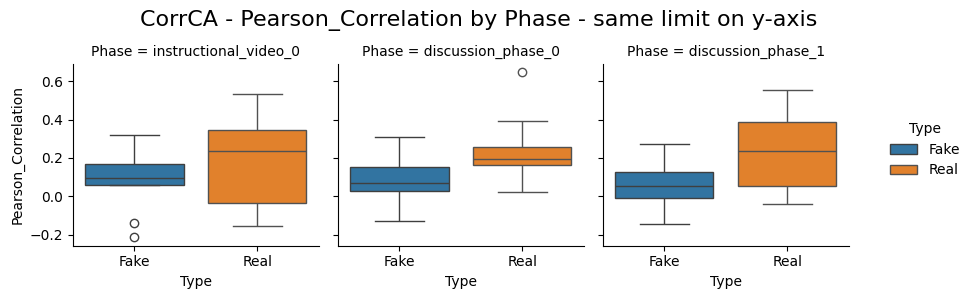

c:\Users\hoekstraf\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


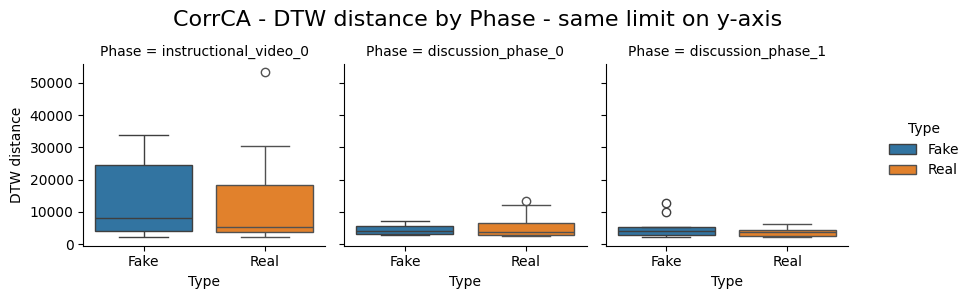

c:\Users\hoekstraf\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


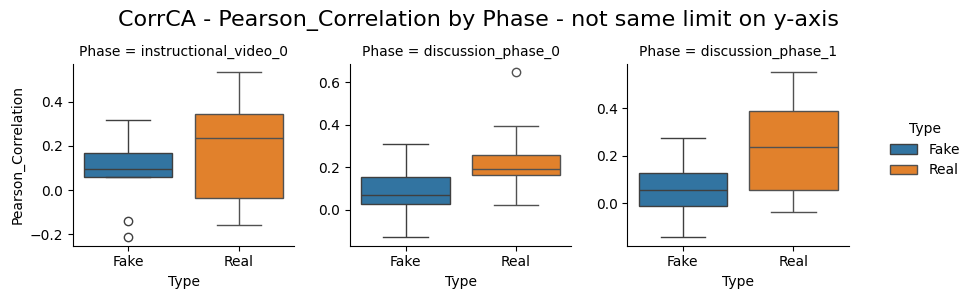

c:\Users\hoekstraf\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


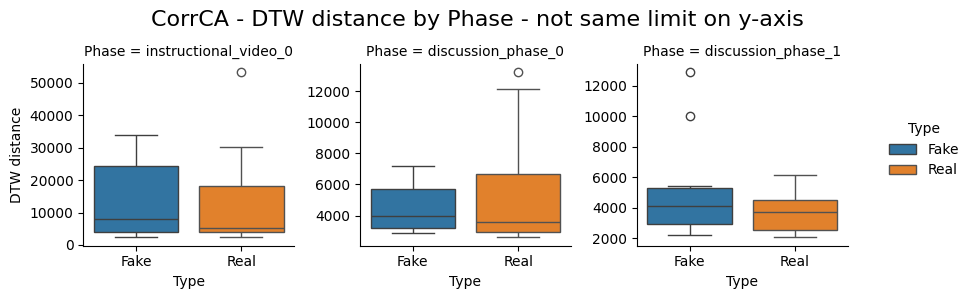

In [ ]:
from functions_face_statistics_corrCA import load_results_corrCA
path_to_corrCA_folder = os.path.join(path_to_new_data, 'Results facial expressions', 'corrCA')

load_results_corrCA(path_to_new_data,path_to_corrCA_folder)